# Exercise 3 - CNNs, ResNets and LR-Scheduling

 * Deep Learning for Computer Vision – Winter Term 2022/23
 * Organizers: Anwai Archit, Laura Hansel, Michaela Vystrcilova, Constantin Pape
 * Tutors: Anwai Archit, Mai Elshazly, Andreas Schneider, Fabio Seel, Shashwat Sridhar
 * Due date: **Monday, Dec 5, before 14:00**

### Time required to solve this exercise sheet
**As you will train a large number of models on this exercise sheet, model training will require an increased amount of time. So we recommend to start working on this sheet early.**

### Topics

In this exercise sheet, you will:
- work again with CIFAR-10
- implement a 1-layer CNN
- compare MLP and CNN
- vary architecture to improve model performance
- implement a ResNet for CIFAR-10
- learn about learning rate scheduling
- [learn about transfer learning]

*We are looking forward to seeing your solutions! Have fun!*

# IMPORTANT SUBMISSION INSTRUCTIONS

You should work on the exercises in groups of 2-3. It is on you how you collaborate, but please make sure that everyone contributes equally and also that you understand all the solutions.
You will be asked to present your group's solution in the tutorials and you should be well prepared to present any part of it.

- When you've completed the exercise, download the notebook and rename it to ```<surname1>_<surname2>_<surname3>.ipynb```.
- Only submit the Jupyter Notebook (ipynb file). No other file is required. Upload it on `Stud.IP` -> `Deep Learning for Computer Vision` -> `Files` -> `Submission of Homework 3`.
- Make only one submission of the exercise per group.
- The deadline is strict.
- In addition to the submissions, every member of your group should be prepared to present the exercise in the tutorials.

Implementation
- Do not change the cells which are marked as "DO NOT CHANGE", similarly write your solution to the marked cells.

### Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau, ExponentialLR, StepLR
import torchvision
from torchvision import datasets, transforms, models
import fastprogress
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import time

## 1. Setup

You can use the functions to grab the data, split the sets and create the dataloaders, etc. given to you at exercise sheet 2.

It is good practice to store functions that are constantly needed again in a separate file such that instead of copy-pasting the cells into each exercise notebook, you can use the python file containing the functions and import it in the notebooks.

If you work with Kaggle (which is recommended) you have to mount the drive first and create a path to your python module (or download the file from your drive).

#### **TODO**
Create a file named 'utils.py' and import it here. You can import any package necessary.

In [2]:
import sys
sys.path.insert(1, '/kaggle/input/dl-utilities')
import utils
import os

## 2. Load dataset, create dataloader, etc.

#### **TODO**
Call the functions of 'utils.py' to instantiate the train-, test- and validation datasets along with their dataloaders.

In [3]:
# DO NOT CHANGE
device = utils.get_device()

# Get number of cpus to use for faster parallelized data loading
num_cpus = os.cpu_count()
print(num_cpus, 'CPUs available')

cuda available: True ; cudnn available: True ; num devices: 2
Using device Tesla T4
2 CPUs available


In [4]:
data_dir = 'data'
batch_size = 256

trainset, testset, dataset_mean, dataset_std = utils.grab_data(data_dir)
trainset, valset = utils.generate_train_val_data_split(trainset)
trainloader, valloader, testloader = utils.init_data_loaders(trainset, valset, testset, batch_size)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


#### **TODO** 
Define the loss function. We use the cross entropy loss again.

In [6]:
loss_function = torch.nn.CrossEntropyLoss()

## 3. Simple 1-layer CNN model

### **TODO**
- Define the model.

The first step to training a model is defining its architecture. 
Define a sequential model with following structure:
*   Convolutional layer with 32 filters, kernel size of 5*5 and stride of 1.
*   Max Pooling layer with kernel size of 2*2 and default stride.
*   ReLU Activation Layers.
*   Linear layer with output of 512.
*   ReLU Activation Layers.
*   A linear layer with output of 10.

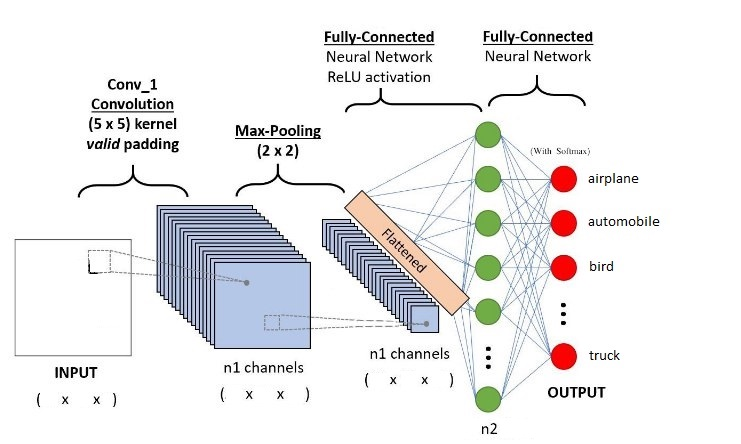

#### **Questions**

- What are the input dimensions?
- What are the dimensions of the feature maps?
- What are the dimensions after pooling?
- What is the value for n2 (in_features)?
- What is the number of parameters for conv_1?

**Your answers here**
- 32x32x3
- 28x28x32
- 

In [7]:
class CNN(nn.Module):
    """Convolutional Neural Network"""
    def __init__(self, img_width, num_in_channels, conv_kernel_size,
                 pool_kernel_size, num_classes, first_linear_output=512):
        """Intialize CNN model
        
        Args:
            img_width (int): Width of images
            num_in_channels (int): Number of input channels of images
            conv_kernel_size (int): Convulational layer size kernel
            pool_kernel_size (int): Pool layer size kernel
            num_classes (int): Number of classes to predict
            first_linear_output (int, optional): Number of output of the first linear layer
                Defaults to 512.
        """
        super(CNN, self).__init__()
        
        self.conv_1 = nn.Conv2d(num_in_channels, img_width,
                                conv_kernel_size) # (3, 32, 5)
        self.pool = nn.MaxPool2d(pool_kernel_size) # 2
        
        self.fc1 = nn.Linear(img_width * pool_kernel_size * pool_kernel_size,
                             first_linear_output) # (32 * 5 * 5, 512)
        self.fc2 = nn.Linear(first_linear_output, num_classes) # (512, 10)
        
        self.act_fn = torch.nn.ReLU()
    
    def forward(self, x):
        """Compute model predictions.

        Args:
            x (torch.Tensor, shape (batchsize, num_channels, x, y)): Tensor of
                batch of input images

        Returns:
            torch.Tensor, shape (batchsize, num_classes): Tensor of model
                predictions
        """
        # Convolution, pool and activation layers
        x = self.pool(self.act_fn(self.conv_1(x)))
        # Flatten
        x = torch.flatten(x, 1)
        # Linear and activation layers
        x = self.act_fn(self.fc1(x))
        x = self.fc2(x)
        
        return x

#### **TODO**

- Train the model for 10 epochs. Use a learning rate of 0.001.
- Plot the results of accuracy and loss as you did in exercise sheet 2.

Finished training after 156 seconds.


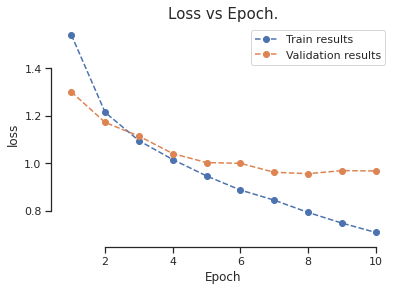

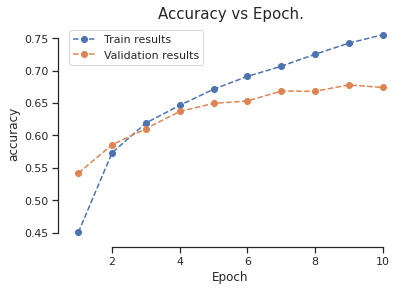

In [9]:
# Model declaration
model = CNN(32, 3, 5, 5, 10)
model = model.to(device)

# Training
lr = 1e-3
epochs = 10
optimizer = torch.optim.Adam(model.parameters(), lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = utils.run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)

# Plotting
utils.plot("Loss vs Epoch.", "loss", train_losses, val_losses)
utils.plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs)

#### **TODO**
Compare results to MLP. What can you observe?

**Your answers here**

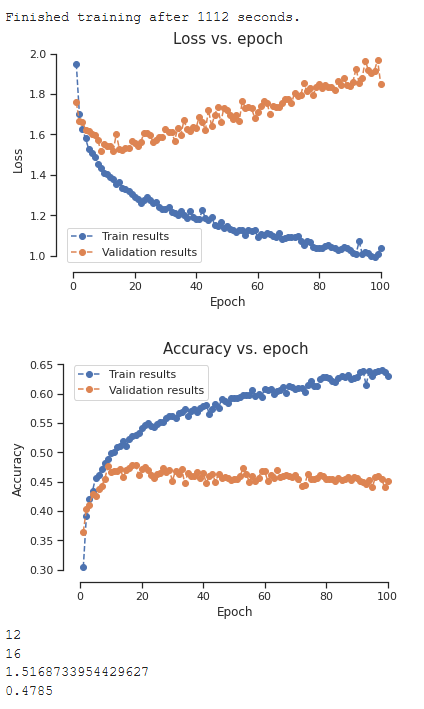

#### **TODO** 
Train longer (ca. 60 epochs), plot again.

Finished training after 1534 seconds.


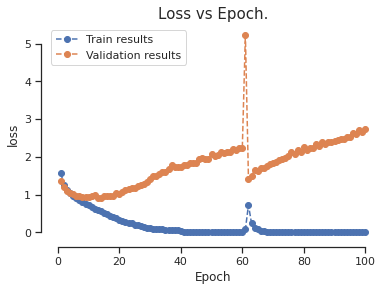

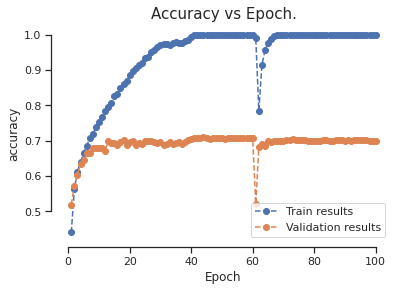

In [10]:
# Model declaration
model = CNN(32, 3, 5, 5, 10)
model = model.to(device)

# Training
lr = 1e-3
epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr)

train_losses, val_losses, train_accs, val_accs, confusion_matrix = utils.run_training(model, optimizer, loss_function, device, epochs, trainloader, valloader)

# Plotting
utils.plot("Loss vs Epoch.", "loss", train_losses, val_losses)
utils.plot("Accuracy vs Epoch.", "accuracy", train_accs, val_accs)

#### **Questions**
- Why is that not an optimal model?
- What could be improved?

**Your answers here**

## 4. CNN model with more convolutional layers

#### **TODO**
Define the architecture displayed in the graphic.

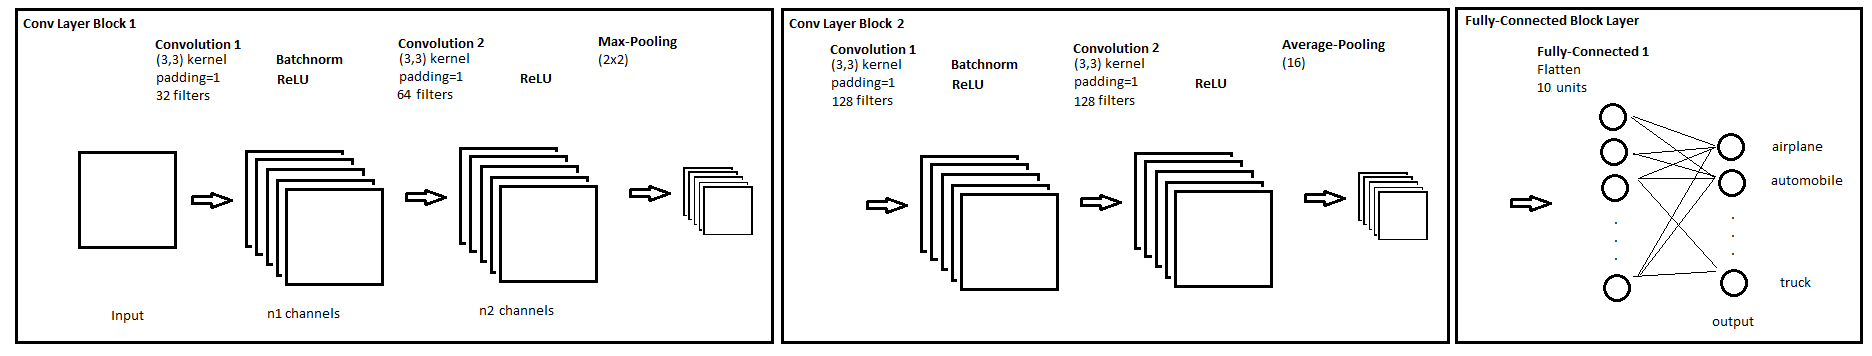

#### **Questions**

- Padding is used in the convolutional layers. What does that mean, which variants exist and how does it influence the dimensions of the feature maps?
- What does padding=1 mean in the case of the network displayed above?
- What are the dimensions of the feature maps after the 1. conv layer?
- What are the dimensions of the feature maps after the 2. conv layer?
- What ist the receptive field size after the first two convolutions?
- What is the value for the in_features for the fully-connected layer?
- What is the number of parameters of *Conv Layer block 1*?

**Your answers here**

In [ ]:
#TODO define model 2

#### **TODO** 

- train the new net (30 epochs, lr=0.1), plot the results, and compare the results to the 1-layer CNN
- explain why you observe these results

In [ ]:
# TODO train and plot

## 5. ResNet architecture

"*Deeper neural networks are more difficult to train.  We present a residual learning framework to ease the training of networks that are substantially deeper than those used previously.*" [ https://arxiv.org/pdf/1512.03385.pdf]

That was the intention of He et al. to develop residual networks.

A ResNet is built of blocks which are called the *Residual Blocks*. 
A residual block uses *skip connections* - shortCuts — to jump over some layers to skip some activations.
The Resnet skips connections via addition.

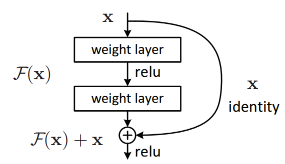

#### **Questions**
- Which problems do using skip connections solve?
- Why is a residual network called residual? 
- When is the advantage of ResNets over 'normal' CNNs most visible?

**Your answers here**

#### **TODO**
- write a class **ResidualBlock(nn.Module)** where you define the blocks used in the ResNet
- write a class **ResNet(nn.Module)** where you define the model
- train the model
- plot results

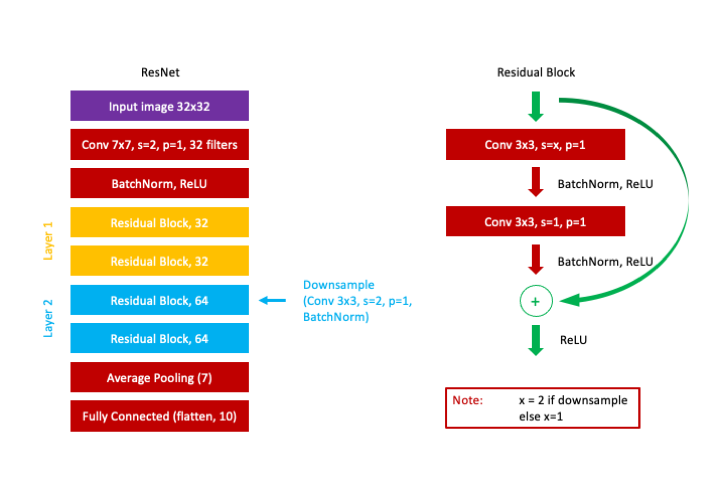

**Hints**

- The downsampling in this ResNet happens between layer 1 and layer 2. In this step, the channel size is increased (32 -> 64) and the image resolution is downsampled by strided convolution (stride=2 in the Conv2d layers).
- For the adding part, the dimensions obviously have to be the same. This is accomplished by using stride=2 in the first Conv2d layer of the block while the second layer does not change the dimensions.
- The average-pooling layer has kernel size 7.
- For you to ensure everything works fine, here are the shapes in the form [(batchsize), x, y, channel] where I discard batchsize, because it does not change.
32x32x3 -> conv 7x7 -> 14x14x32 -> layer 1 -> 14x14x32 -> layer2 -> 7x7x64 -> avpool(7) -> 1x1x64 -> linear(64, 10)

In [ ]:
# TODO write a class ResidualBlock(nn.Module) where you define the blocks used in the ResNet

In [ ]:
# TODO write a class ResNet(nn.Module) where you define the model

In [ ]:
# TODO train ResNet, using the architecture laid out in the comments and figures above

In [ ]:
# TODO plot loss and accuracy for training and validation set

#### **Questions**
- Does the performance increase compared to the CNNs you trained before? Why/Why not?
- Compare the runtime of CNN and ResNet.

**Your answers here**

## 6. Explore Learning Rate Scheduling

Learning rate scheduling is a mechanism to adjust the learning rate.

*torch.optim.lr_scheduler* provides several methods based on the number of epochs. Learning rate scheduling should be applied after optimizer’s update.

#### **TODO**
- change run_training and extend to use scheduler for learning rate
- use StepLR (https://pytorch.org/docs/stable/optim.html), use the ResNet, train for 10 epochs. Start with a learning rate of 0.1.


#### **Questions**

- Try step size 1, gamma 0.1
    - How does it change the learning rate?
    - what do you observe regarding performance?
- Try step size 1, gamma 0.9, what do you observe?
    - How does it change the learning rate?
    - what do you observe regarding performance?
- What can you conclude of this experiment regarding the synergy of step size and gamma to get a good schedule?

**Your answers here**

In [ ]:
# TODO change run_training (you can copy the code from utils.py here and create a new method here 
# or just change/create a new method it in the python file)

In [ ]:
# TODO train and plot with step size 1, gamma 0.1

In [ ]:
# TODO train and plot with step size 1, gamma 0.9

#### **TODO** 

Use step size 15, gamma 0.1. Train for 30 epochs.

#### **Questions**
- Does it improve performance?
- What can you observe in the plots?

**Your answers here**

In [ ]:
# TODO train and plot with step size 15, gamma 0.1, 30 epochs.

## [7. Optional LR-Scheduling]

#### **TODO**
- try two more scheduler: ExponentialLR and ReduceLROnPlateau 
- vary the parameters, which work best?
- does it improve performance compared to no scheduler?
- does it improve performance compared to StepLR?

**Your answers here**

In [ ]:
# TODO train and plot

## [8. Optional Transfer Learning]

### **TODO**

- load a pretrained ResNet from torchvision
- freeze the parameters so that the gradients are not computed
- replace the last fully-connected layer
- fine-tune the model
- plot the results again and compare to approaches before
    - is a better performance reached? why/why not?
    - does it take more/less time to fine-tune compared to train a resnet?

**Your answers here**

In [ ]:
# TODO do transfer learning with resnet on cifar10